In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
# ML imports
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

/home/titli/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/titli/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
u1 = pd.read_csv('test_results.csv') #index_col = 'user_id')
u1 = u1.drop(['Unnamed: 0'], axis=1)
u2 = pd.read_csv('user_table.csv')
results =  u1[~u1.timestamp.isnull()]
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [3]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316466 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316466 non-null int64
timestamp           316466 non-null object
source              316154 non-null object
device              316466 non-null object
operative_system    296140 non-null object
test                316466 non-null int64
price               316466 non-null float64
converted           316466 non-null int64
dtypes: float64(1), int64(3), object(4)
memory usage: 21.7+ MB


In [4]:
def fixprice(row):
    if (row['price'])>100:
        if row.test ==1:
            return(39.0)
        else:
            return(59.0)
    else:
        return(row['price'])

In [5]:
results['price_new'] = results.apply(lambda row: fixprice(row), axis=1)
results.head()

/home/titli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,source,device,operative_system,test,price,converted,price_new
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,39.0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,39.0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,39.0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,59.0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,39.0


In [6]:
# Display conversion rates per country
price_conversion_rate = []
for price in results.price_new.unique():
    price_conversion_rate.append((price, 
                                    results[results.price_new == price].converted.sum() * 1.0 / 
                                    results[results.price_new == price].shape[0]))

In [7]:
price_conversion_rate

[(39.0, 0.019851953216026338), (59.0, 0.0156744181994023)]

/home/titli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0,0.5,'Conversion Rate')

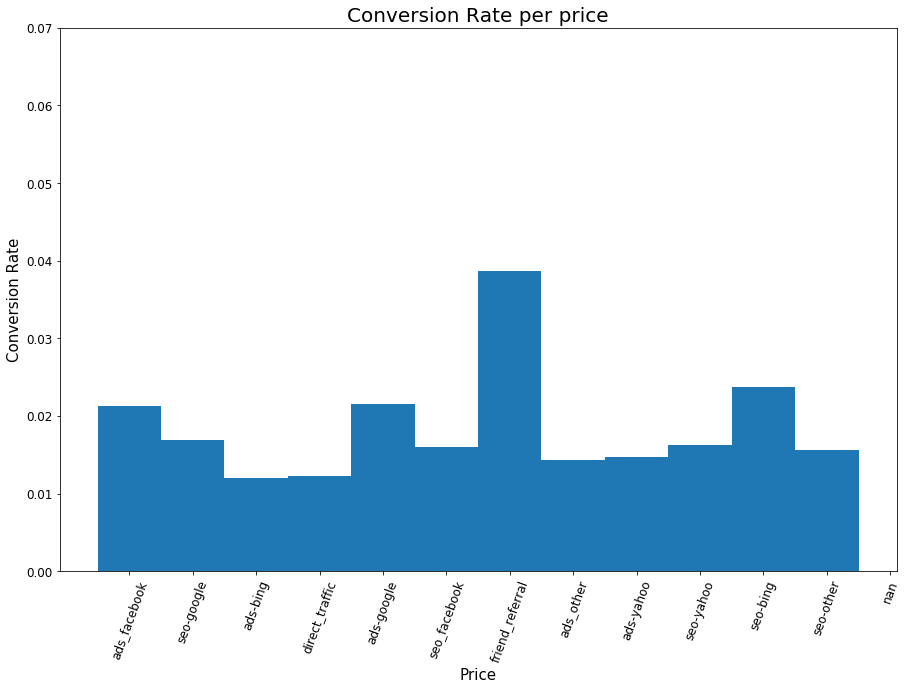

In [8]:
# Display conversion rates per country
country_conversion_rate = []
for source in results.source.unique():
    country_conversion_rate.append((source, 
                                    results[results.source == source].converted.sum() * 1.0 / 
                                    results[results.source == source].shape[0]))

labels, ys = zip(*country_conversion_rate)
xs = np.arange(len(labels)) 
width = 1
plt.figure(figsize=(15,10))
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=12)

plt.title("Conversion Rate per price", fontsize=20)
plt.xlabel("Price", fontsize=15)
plt.ylabel("Conversion Rate", fontsize=15)

/home/titli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0,0.5,'Conversion Rate')

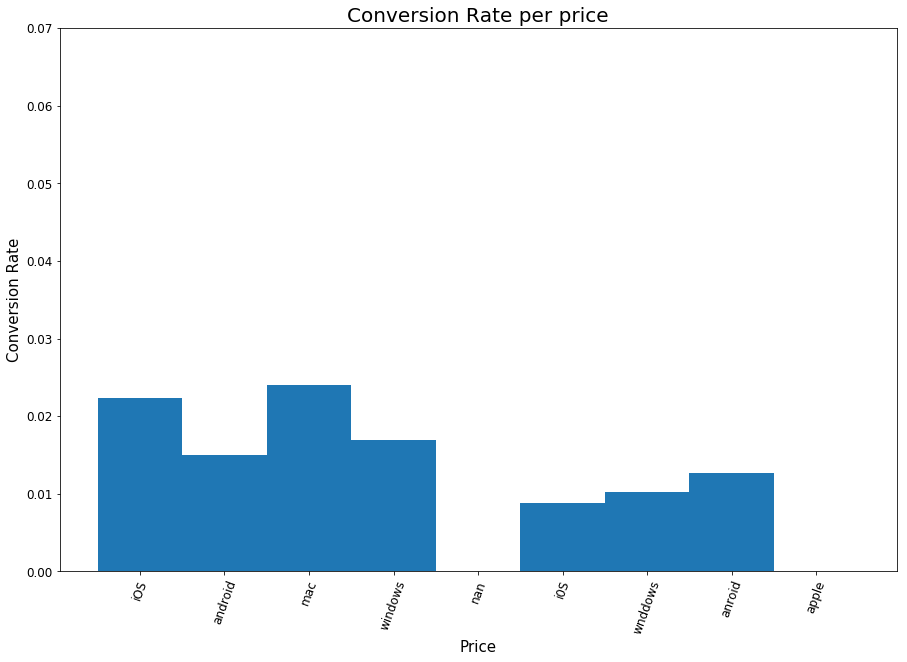

In [9]:
# Display conversion rates per country
operating_system_conversion_rate = []
for source in results.operative_system.unique():
    operating_system_conversion_rate.append((source, 
                                    results[results.operative_system == source].converted.sum() * 1.0 / 
                                    results[results.operative_system == source].shape[0]))

labels, ys = zip(*operating_system_conversion_rate)
xs = np.arange(len(labels)) 
width = 1
plt.figure(figsize=(15,10))
plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels, fontsize=12, rotation=70)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=12)

plt.title("Conversion Rate per price", fontsize=20)
plt.xlabel("Price", fontsize=15)
plt.ylabel("Conversion Rate", fontsize=15)


### Time correction

In [10]:
new_stamp =[]
for i in range(len(results)): #
    try:
        time_list = re.split('[- :]',results.timestamp[i])
        if int(time_list[5])>59:
            time_list[5]= '0'+str(int(time_list[5])-59)
            time_list[4]= str(int(time_list[4])+1)
            #print(time_list[4])
        elif int(time_list[4])>59:
            time_list[4]= '0'+str(int(time_list[4])-59)
            time_list[3]= str(int(time_list[3])+1)
        elif int(time_list[3])>23:
            time_list[3]= '0'+str(int(time_list[3])-23)
            time_list[2]= str(int(time_list[2])+1)
        new_stamp.append(str('-'.join(time_list[0:3])+' '+':'.join(time_list[3:6])))
    except:
        new_stamp.append('NO')
    #print((time_list[4]))
    #print(str('-'.join(time_list[0:3])+' '+':'.join(time_list[3:6])))
    

In [11]:
results.timestamp = new_stamp
cleaned_data = results[~(results.timestamp=='NO')]

/home/titli/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
interval_conversion = pd.DataFrame()
interval_conversion['access_time'] = pd.to_datetime(cleaned_data['timestamp'], errors = 'coerce')
interval_conversion['count']= cleaned_data['converted']
interval_conversion.set_index('access_time', inplace = True)

In [13]:
interval_conversion.head()

,count
access_time,
2015-05-08 03:38:34,0
2015-05-10 21:08:46,0
2015-04-04 15:01:23,0
2015-05-07 07:26:01,0
2015-05-24 11:04:40,0


Text(0,0.5,'Mean conversion rate')

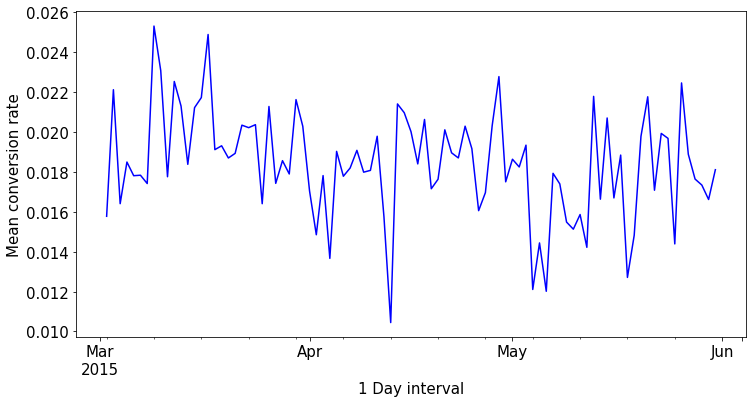

In [14]:
interval_days = interval_conversion.resample('1D').mean()
interval_days.plot(color='blue', fontsize=15, figsize=(12, 6), legend = False)
plt.xlabel('1 Day interval', fontsize = 15)
plt.ylabel('Mean conversion rate', fontsize = 15)
#index_month = logins.index.week

### Combining user table

In [15]:
u2.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [16]:
def getreviews(user_ids, users, original):
    """ gets one text review for each user in user_ids list"""
    result=[]
    for i in range(len(original)):
        if users['user_id'].iloc[i] in user_ids: 
            result.append({'city': users.city.iloc[i], 'country': users.country.iloc[i], 'source': original.source.iloc[i], \
                          'device': original.device.iloc[i], 'operative': original.operative_system.iloc[i], \
                           'price': original.price_new.iloc[i]})
    reviewdata = pd.DataFrame(result)
    return reviewdata

In [17]:
user_ids= u1.user_id.unique()
review_texts_all = getreviews(user_ids,u2,results)

IndexError: single positional indexer is out-of-bounds

In [ ]:
review_texts_all.head()

In [18]:
dummies = pd.DataFrame()
# Create dummy variables for country values
source_dummies = pd.get_dummies(results.source, prefix='source')
dummies = pd.concat([dummies, source_dummies], axis=1)
# Create dummy variables for source values
device_dummies = pd.get_dummies(results.device, prefix='device')
dummies = pd.concat([dummies, source_dummies], axis=1)
operative_system_dummies = pd.get_dummies(results.device, prefix='operative_system')
dummies = pd.concat([dummies, operative_system_dummies], axis=1)
dummies = pd.concat([dummies, results.price_new], axis=1)
dummies.head()


,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,...,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,operative_system_mobile,operative_system_web,price_new
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,39.0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,39.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,39.0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,59.0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,39.0


In [19]:
X = dummies
Y = results.converted
# Split data
X_dev, X_eval, Y_dev, Y_eval = train_test_split(X, Y, train_size=.7, random_state=23)

# Initialize a random forest classifier
rf = RandomForestClassifier(class_weight="balanced")

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'criterion': ['gini', 'entropy']}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(rf, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

rf_best = clf.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=200, max_depth=3, criterion=entropy ................
[CV] n_estimators=200, max_depth=3, criterion=entropy ................
[CV] n_estimators=200, max_depth=3, criterion=entropy ................
[CV] n_estimators=200, max_depth=3, criterion=entropy ................
[CV] n_estimators=200, max_depth=3, criterion=entropy ................
[CV] n_estimators=50, max_depth=5, criterion=gini ....................
[CV] n_estimators=50, max_depth=5, criterion=gini ....................
[CV] n_estimators=50, max_depth=5, criterion=gini ....................
[CV] n_estimators=50, max_depth=5, criterion=gini ....................
[CV] n_estimators=50, max_depth=5, criterion=gini ....................
[CV]  n_estimators=50, max_depth=5, criterion=gini, score=0.633111 -  17.1s
[CV] n_estimators=150, max_depth=5, criterion=gini ...................
[CV]  n_estimators=50, max_depth=5, criterion=gini, score=0.639002 -  17.2s
[CV] n

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   19.1s


[CV]  n_estimators=200, max_depth=3, criterion=entropy, score=0.580034 -  43.8s
[CV] n_estimators=200, max_depth=3, criterion=gini ...................
[CV]  n_estimators=200, max_depth=3, criterion=entropy, score=0.607877 -  44.3s
[CV]  n_estimators=200, max_depth=3, criterion=entropy, score=0.639002 -  44.3s
[CV] n_estimators=200, max_depth=3, criterion=gini ...................
[CV] n_estimators=200, max_depth=3, criterion=gini ...................
[CV]  n_estimators=200, max_depth=3, criterion=entropy, score=0.633111 -  45.2s
[CV] n_estimators=200, max_depth=3, criterion=gini ...................
[CV]  n_estimators=200, max_depth=3, criterion=entropy, score=0.606388 -  45.3s
[CV] n_estimators=200, max_depth=3, criterion=gini ...................
[CV]  n_estimators=150, max_depth=5, criterion=gini, score=0.633111 -  50.9s
[CV] n_estimators=100, max_depth=3, criterion=gini ...................
[CV]  n_estimators=150, max_depth=5, criterion=gini, score=0.602514 -  51.8s
[CV]  n_estimators=1

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.2min


[CV]  n_estimators=150, max_depth=5, criterion=gini, score=0.639002 -  51.1s
[CV] n_estimators=100, max_depth=3, criterion=gini ...................
[CV]  n_estimators=150, max_depth=5, criterion=gini, score=0.636858 -  51.2s
[CV] n_estimators=100, max_depth=3, criterion=gini ...................
[CV]  n_estimators=200, max_depth=3, criterion=gini, score=0.641869 -  44.6s
[CV] n_estimators=50, max_depth=5, criterion=entropy .................
[CV]  n_estimators=200, max_depth=3, criterion=gini, score=0.633111 -  45.4s
[CV] n_estimators=50, max_depth=5, criterion=entropy .................
[CV]  n_estimators=200, max_depth=3, criterion=gini, score=0.604817 -  46.3s
[CV] n_estimators=50, max_depth=5, criterion=entropy .................
[CV]  n_estimators=200, max_depth=3, criterion=gini, score=0.639002 -  45.8s
[CV] n_estimators=50, max_depth=5, criterion=entropy .................
[CV]  n_estimators=100, max_depth=3, criterion=gini, score=0.604817 -  22.6s
[CV] n_estimators=50, max_depth=5, 

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.5min


[CV]  n_estimators=100, max_depth=3, criterion=gini, score=0.639002 -  22.5s
[CV] n_estimators=50, max_depth=3, criterion=gini ....................
[CV]  n_estimators=100, max_depth=3, criterion=gini, score=0.641869 -  23.6s
[CV] n_estimators=50, max_depth=3, criterion=gini ....................
[CV]  n_estimators=100, max_depth=3, criterion=gini, score=0.637693 -  23.8s
[CV] n_estimators=50, max_depth=3, criterion=gini ....................
[CV]  n_estimators=100, max_depth=3, criterion=gini, score=0.639228 -  23.3s
[CV] n_estimators=50, max_depth=3, criterion=gini ....................
[CV]  n_estimators=50, max_depth=3, criterion=gini, score=0.580034 -  12.0s
[CV] n_estimators=100, max_depth=5, criterion=gini ...................
[CV]  n_estimators=50, max_depth=3, criterion=gini, score=0.618982 -  11.8s
[CV] n_estimators=100, max_depth=5, criterion=gini ...................
[CV]  n_estimators=50, max_depth=3, criterion=gini, score=0.639657 -  11.2s
[CV]  n_estimators=50, max_depth=3, cr

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.8min


[CV]  n_estimators=50, max_depth=5, criterion=entropy, score=0.604817 -  17.5s
[CV] n_estimators=200, max_depth=5, criterion=entropy ................
[CV]  n_estimators=50, max_depth=5, criterion=entropy, score=0.607877 -  17.5s
[CV] n_estimators=200, max_depth=5, criterion=entropy ................
[CV]  n_estimators=50, max_depth=5, criterion=entropy, score=0.633111 -  17.9s
[CV] n_estimators=200, max_depth=5, criterion=entropy ................
[CV]  n_estimators=50, max_depth=5, criterion=entropy, score=0.666968 -  17.7s
[CV] n_estimators=200, max_depth=5, criterion=entropy ................
[CV]  n_estimators=50, max_depth=5, criterion=entropy, score=0.639002 -  18.4s
[CV] n_estimators=200, max_depth=5, criterion=entropy ................
[CV]  n_estimators=100, max_depth=5, criterion=gini, score=0.587934 -  33.9s
[CV] n_estimators=200, max_depth=5, criterion=gini ...................
[CV]  n_estimators=100, max_depth=5, criterion=gini, score=0.633111 -  34.2s
[CV] n_estimators=200, ma

[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:  2.3min remaining:   48.8s


[CV]  n_estimators=100, max_depth=5, criterion=gini, score=0.639002 -  34.5s
[CV] n_estimators=200, max_depth=5, criterion=gini ...................
[CV]  n_estimators=100, max_depth=5, criterion=gini, score=0.639228 -  34.2s
[CV] n_estimators=200, max_depth=5, criterion=gini ...................
[CV]  n_estimators=200, max_depth=5, criterion=entropy, score=0.602514 - 1.1min
[CV]  n_estimators=200, max_depth=5, criterion=entropy, score=0.660964 - 1.1min
[CV]  n_estimators=200, max_depth=5, criterion=entropy, score=0.604153 - 1.1min


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:  2.9min remaining:   28.5s


[CV]  n_estimators=200, max_depth=5, criterion=entropy, score=0.639002 - 1.1min
[CV]  n_estimators=200, max_depth=5, criterion=entropy, score=0.635098 - 1.1min
[CV]  n_estimators=200, max_depth=5, criterion=gini, score=0.602514 -  51.6s
[CV]  n_estimators=200, max_depth=5, criterion=gini, score=0.604153 -  50.8s
[CV]  n_estimators=200, max_depth=5, criterion=gini, score=0.660964 -  51.4s
[CV]  n_estimators=200, max_depth=5, criterion=gini, score=0.639002 -  51.1s
[CV]  n_estimators=200, max_depth=5, criterion=gini, score=0.635098 -  50.9s


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  3.2min finished


Classification report for Random Forest
             precision    recall  f1-score   support

unconverted       0.98      0.64      0.78     93178
  converted       0.02      0.47      0.05      1762

avg / total       0.97      0.64      0.76     94940

Area under ROC curve: 0.557


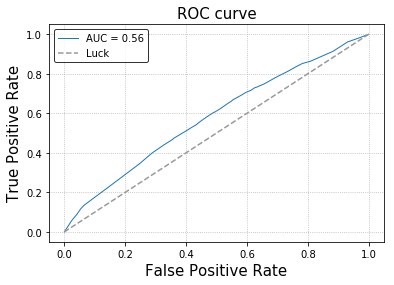

In [20]:
# Collect RF predictions
rf_Ypredicted = rf_best.predict(X_eval)
rf_roc_auc = roc_auc_score(Y_eval, rf_Ypredicted)

print ("Classification report for Random Forest")
print (classification_report(Y_eval, 
                            rf_Ypredicted,
                            target_names=["unconverted", "converted"]))
print ("Area under ROC curve: {:0.3f}".format(rf_roc_auc))


# Compute ROC curve and area under the curve for RF
rf_probs = rf_best.predict_proba(X_eval)[:, 1]
rf_fpr, rf_tpr, thresholds = roc_curve(Y_eval, rf_probs)

plt.plot(rf_fpr, rf_tpr, lw=1, label='AUC = %0.2f'%(rf_roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('ROC curve', fontsize=15)
plt.legend(loc="best", frameon = True).get_frame().set_edgecolor('black')
plt.grid(True, linestyle = 'dotted')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

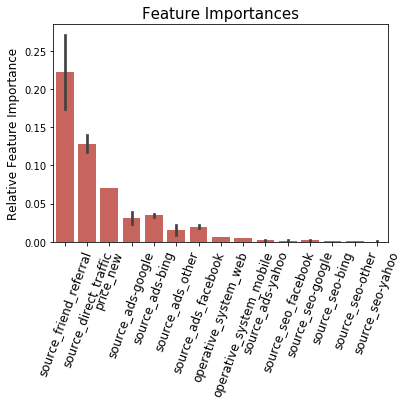

In [21]:
# For random forest, look at most important features
feat_labels = X.columns
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

sns.barplot(x=feat_labels[indices], y=importances[indices], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=70)

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize a random forest classifier
gbc = GradientBoostingClassifier()

# Define a parameter grid to search over
param_dist = {"n_estimators": range(50, 250, 50),
              "max_depth": range(3, 7, 2), 
              'learning_rate': [.01, .03, .1, .3]}

# Setup 5-fold stratified cross validation
cross_validation = StratifiedKFold(Y_dev, n_folds=5)

# Randomly sample 10 hyperparameter configurations from the grid above and perform 5-fold cross validation for each
n_iter_search = 10
clf = RandomizedSearchCV(gbc, 
                         param_distributions=param_dist, 
                         n_iter=n_iter_search, 
                         cv=cross_validation, 
                         n_jobs=10, 
                         verbose=10)
_ = clf.fit(X_dev, Y_dev)

gbc_best = clf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, max_depth=5, learning_rate=0.03 ...............
[CV] n_estimators=100, max_depth=5, learning_rate=0.03 ...............
[CV] n_estimators=100, max_depth=5, learning_rate=0.03 ...............
[CV] n_estimators=100, max_depth=5, learning_rate=0.03 ...............
[CV] n_estimators=100, max_depth=5, learning_rate=0.03 ...............
[CV] n_estimators=150, max_depth=5, learning_rate=0.3 ................
[CV] n_estimators=150, max_depth=5, learning_rate=0.3 ................
[CV] n_estimators=150, max_depth=5, learning_rate=0.3 ................
[CV] n_estimators=150, max_depth=5, learning_rate=0.3 ................
[CV] n_estimators=150, max_depth=5, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.03, score=0.981763 - 2.6min
[CV] n_estimators=200, max_depth=5, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.03, score=0.981763 - 2.6

[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  2.6min


[CV]  n_estimators=150, max_depth=5, learning_rate=0.3, score=0.981763 - 3.8min
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.3, score=0.981763 - 3.8min
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.3, score=0.981763 - 3.9min
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.3, score=0.981741 - 3.9min
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.3, score=0.981763 - 4.0min
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.981741 - 2.4min
[CV] n_estimators=100, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.981763 - 2.4min
[CV] n_estim

[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  6.3min


[CV] n_estimators=100, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.981763 - 2.4min
[CV] n_estimators=100, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.981763 - 2.4min
[CV] n_estimators=100, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=200, max_depth=5, learning_rate=0.3, score=0.981763 - 5.1min
[CV] n_estimators=100, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=200, max_depth=5, learning_rate=0.3, score=0.981763 - 5.2min
[CV] n_estimators=100, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=200, max_depth=5, learning_rate=0.3, score=0.981763 - 5.2min
[CV] n_estimators=100, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=100, max_depth=3, learning_rate=0.01, score=0.981741 - 1.6min
[CV] n_estimators=100, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=2

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  7.8min


[CV]  n_estimators=100, max_depth=3, learning_rate=0.01, score=0.981763 - 1.6min
[CV] n_estimators=200, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.01, score=0.981763 - 1.6min
[CV] n_estimators=200, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.01, score=0.981763 - 1.6min
[CV] n_estimators=200, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=3, learning_rate=0.01, score=0.981763 - 1.6min
[CV] n_estimators=200, max_depth=3, learning_rate=0.3 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.01, score=0.981741 - 2.7min
[CV] n_estimators=100, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.01, score=0.981763 - 2.7min
[CV] n_estimators=100, max_depth=5, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.01, score=0.981763 - 2.7min
[CV] n_

[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 10.6min


[CV]  n_estimators=200, max_depth=3, learning_rate=0.3, score=0.981741 - 3.1min
[CV] n_estimators=200, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=3, learning_rate=0.3, score=0.981763 - 3.1min
[CV] n_estimators=200, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=3, learning_rate=0.3, score=0.981763 - 3.2min
[CV] n_estimators=200, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=3, learning_rate=0.3, score=0.981763 - 3.1min
[CV] n_estimators=200, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=3, learning_rate=0.3, score=0.981763 - 3.1min
[CV] n_estimators=200, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.981763 - 2.7min
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.981741 - 2.8min
[CV] n_estimat

[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed: 13.2min remaining:  4.6min


[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.981763 - 2.7min
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.981763 - 2.7min
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=100, max_depth=5, learning_rate=0.1, score=0.981763 - 2.7min
[CV] n_estimators=100, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=200, max_depth=3, learning_rate=0.1, score=0.981741 - 3.1min
[CV]  n_estimators=200, max_depth=3, learning_rate=0.1, score=0.981763 - 3.2min
[CV]  n_estimators=200, max_depth=3, learning_rate=0.1, score=0.981763 - 3.2min


[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed: 14.2min remaining:  2.3min


[CV]  n_estimators=200, max_depth=3, learning_rate=0.1, score=0.981763 - 3.2min
[CV]  n_estimators=200, max_depth=3, learning_rate=0.1, score=0.981763 - 3.2min
[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.981741 - 1.4min
[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.981763 - 1.3min
[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.981763 - 1.3min
[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.981763 - 1.4min
[CV]  n_estimators=100, max_depth=3, learning_rate=0.1, score=0.981763 - 1.3min


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 14.6min finished


Text(0,0.5,'Partial Dependence')

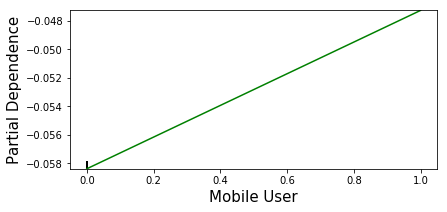

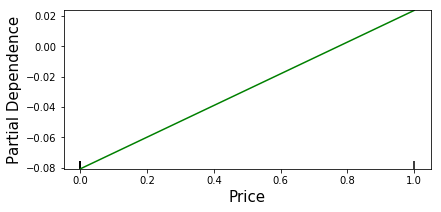

In [23]:
fig, ax = plot_partial_dependence(gbc_best, X, features=[8])
plt.xlabel("Mobile User", fontsize=15)
plt.ylabel("Partial Dependence", fontsize=15)

fig, ax = plot_partial_dependence(gbc_best, X, features=[3])
plt.xlabel("Price", fontsize=15)
plt.ylabel("Partial Dependence", fontsize=15)
